# Tidyverse example

CPBS 7601

1. Import packages and setup options
2. Load data
3. Clean data
4. Wrangle data
5. Outputs

## Step 1 - Import packages and setup options

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(readr))
suppressPackageStartupMessages(library(ggplot2))

In [2]:
# Set constants and paths
figshare_base_url <- "https://figshare.com/ndownloader/files/"

drug_screen_file_id <- "46630984"
drug_id_file_id <- "46630981"
cellline_file_id <- "46630978"

# Set output file paths
output_directory <- "results"
ttest_results_file <- file.path(output_directory, "ttest_results_tidyverse.csv")
volcano_plot_file <- file.path(output_directory, "volcano_plot_tidyverse.png")

## Step 2 - Load the data

1. Drug screening viability data
2. Drug identifier metadata
3. Cell line identifier metadata

Accessed from the DepMap Drug Repurposing Hub 2024 2Q Data Release.

https://figshare.com/articles/dataset/Repurposing_Public_24Q2/25917643/1?file=46630978

In [3]:
# Load drug screen data
drug_screen_results_df <- readr::read_csv(
    paste0(figshare_base_url, drug_screen_file_id),
    show_col_types = FALSE
    )

# Explore the data
print(dim(drug_screen_results_df))
head(drug_screen_results_df, 3)

New names:
• `` -> `...1`


[1] 6790  920


...1,ACH-000001,ACH-000002,ACH-000004,ACH-000005,ACH-000006,ACH-000007,ACH-000008,ACH-000010,ACH-000011,⋯,ACH-002016,ACH-002022,ACH-002023,ACH-002025,ACH-002038,ACH-002039,ACH-002041,ACH-002042,ACH-002046,ACH-002048
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BRD:BRD-A00047421-001-01-7,-1.20728146,-4.231563,-3.860672,-2.271411,0.2778328,-4.01128501,-0.6151046,-2.6253,-1.827661242,⋯,-1.975287,-2.403487,-0.4957408,-3.238121,1.223419,-2.314389,-2.805922,-2.332483,-3.441262,-1.254407
BRD:BRD-A00055058-001-01-0,0.51574339,NA,NA,NA,NA,0.19687776,0.3478209,NA,-0.001030595,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
BRD:BRD-A00077618-236-07-6,-0.01557664,NA,NA,NA,NA,-0.09573033,0.3794804,NA,0.145346065,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [4]:
# Load compound identifier metadata
compound_id_df <- readr::read_csv(
    paste0(figshare_base_url, drug_id_file_id),
    col_types = readr::cols(
        screen = readr::col_character(),
        repurposing_target = readr::col_character(),
        MOA = readr::col_character(),
        IDs = readr::col_character(),
        Drug.Name = readr::col_character(),
        Synonyms = readr::col_character(),
        dose = readr::col_double()
        )
    )

# Explore the data
print(dim(compound_id_df))
head(compound_id_df, 3)

[1] 6790    7


screen,dose,repurposing_target,MOA,IDs,Drug.Name,Synonyms
<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
REP.300,2.5,NA,NA,BRD:BRD-K00104122-001-01-9,MRTX1133,MRTX1133
REP.300,2.5,NA,NA,BRD:BRD-K00104124-001-01-9,PEMIGATINIB,PEMIGATINIB
REP.300,2.5,NA,NA,BRD:BRD-K00085355-001-01-9,TELAVANCIN,TELAVANCIN


In [5]:
# Load compound identifier metadata
cellline_id_df <- readr::read_csv(
    paste0(figshare_base_url, cellline_file_id),
    col_types = readr::cols(
        .default = readr::col_character()
    )
)

# Explore the data
print(dim(cellline_id_df))
head(cellline_id_df, 3)


[1] 1898    6


ccle_name,row_id,pool_id,culture,depmap_id,screen
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
KYSE510_OESOPHAGUS,ACH-000824::P107::PR500A::REP1M,P107,PR500A,ACH-000824,REP1M
HEC1A_ENDOMETRIUM,ACH-000954::P107::PR500A::REP1M,P107,PR500A,ACH-000954,REP1M
MIAPACA2_PANCREAS,ACH-000601::P101::PR500A::REP1M,P101,PR500A,ACH-000601,REP1M


## Step 3 - Clean data

It's extremely rare for a dataset to not need any cleaning.

Chances are that you will need to fix some column names, isolate certain rows and/or columns for your analysis, remove certain data, and perform other operations to get your data ready for analysis.

Here, we perform a series of data cleaning operations.

Note, that we would have done much of this data cleaning upon data loading, but, for instruction, we do it separately here.

In [6]:
## Step 1 - Rename column 1
drug_screen_results_df <- drug_screen_results_df %>%
  dplyr::rename("BRD_ID" = `...1`)

## Step 2 - Select drugs with known MOA
compounds_with_known_MOA <- compound_id_df %>%
    dplyr::filter(!is.na(MOA)) %>%
    dplyr::distinct(MOA,.keep_all = TRUE) %>%
    dplyr::pull(IDs)

# Step 3 - Filter drug screen data to only include compounds with known MOA
drug_screen_results_df <- drug_screen_results_df %>%
    dplyr::filter(BRD_ID %in% compounds_with_known_MOA)

# Step 4 - Split cell line column to separate name from cancer type
# and keep only certain columns
cellline_id_df <- cellline_id_df %>%
  tidyr::separate(ccle_name, into = c("cell_line", "cancer_type"), sep = "_") %>%
  dplyr::select(cell_line, cancer_type, depmap_id) %>%
  dplyr::distinct()

# Step 5 - Remove screen and dose columns in drug id data
compound_id_df <- compound_id_df %>%
  dplyr::select(-screen, -dose) %>%
  dplyr::distinct()

Warning message:
“Expected 2 pieces. Additional pieces discarded in 809 rows [4, 6, 7, 8, 11, 12,
17, 21, 23, 30, 31, 34, 35, 40, 48, 49, 51, 57, 59, 63, ...].”
Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 40 rows [451, 452, 453,
454, 455, 456, 457, 458, 459, 461, 666, 667, 668, 669, 670, 671, 672, 673, 674,
675, ...].”


## Step 4: Wrangle data

Data are always in an inappropriate form for analysis.

Wrangling data get data in the correct form so that you can apply statistics and machine learning.

In [7]:
# Filter drug screen data to only include data from pancreatic and liver cancers
select_cancer_types <- c("PANCREAS", "LIVER")

pancreatic_cancer_depmap_ids <- cellline_id_df %>%
  dplyr::filter(cancer_type %in% !!select_cancer_types) %>%
  dplyr::pull(depmap_id)

drug_screen_results_df <- drug_screen_results_df %>%
    dplyr::select("BRD_ID", !!pancreatic_cancer_depmap_ids)

In [8]:
# Pivot wide data to long data
drug_screen_results_long_df <- drug_screen_results_df %>%
    tidyr::pivot_longer(
        cols = !BRD_ID,
        names_to = "ach_cell_line_id",
        values_to = "response"
        )

print(dim(drug_screen_results_long_df))
head(drug_screen_results_long_df, 3)

[1] 90560     3


BRD_ID,ach_cell_line_id,response
<chr>,<chr>,<dbl>
BRD:BRD-A00077618-236-07-6,ACH-000601,0.18496495
BRD:BRD-A00077618-236-07-6,ACH-000361,-0.60418762
BRD:BRD-A00077618-236-07-6,ACH-001318,-0.01247979


In [9]:
# Join cell line metadata and drug identifiers
drug_screen_results_long_df <- drug_screen_results_long_df %>%
    dplyr::left_join(cellline_id_df, by = c("ach_cell_line_id" = "depmap_id")) %>%
    dplyr::left_join(compound_id_df, by = c("BRD_ID" = "IDs")) %>%
    dplyr::distinct()

print(dim(drug_screen_results_long_df))
head(drug_screen_results_long_df, 3)

[1] 90560     9


BRD_ID,ach_cell_line_id,response,cell_line,cancer_type,repurposing_target,MOA,Drug.Name,Synonyms
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
BRD:BRD-A00077618-236-07-6,ACH-000601,0.18496495,MIAPACA2,PANCREAS,PRKG1,PKA ACTIVATOR,8-BROMO-CGMP,8-BROMO-CGMP
BRD:BRD-A00077618-236-07-6,ACH-000361,-0.60418762,SKHEP1,LIVER,PRKG1,PKA ACTIVATOR,8-BROMO-CGMP,8-BROMO-CGMP
BRD:BRD-A00077618-236-07-6,ACH-001318,-0.01247979,PLCPRF5,LIVER,PRKG1,PKA ACTIVATOR,8-BROMO-CGMP,8-BROMO-CGMP


## Step 5 - Outputs

We can now analyze the data in any number of ways.

We show here one example:

1. Identifying the most differentially effective MOAs between pancreatic and liver cancers.
2. Visualizing the results.

In [10]:
# Identify all unique MOAs
unique_MOAs <- unique(drug_screen_results_long_df$MOA)

length(unique_MOAs)

[1] 1415

In [11]:
# Calculate t-test for each MOA across pancreatic and liver cancers
ttest_results <- list()
for (moa in unique_MOAs) {
    # Isolate specific moa
    specific_moa_drug_screen_results_long_df <- drug_screen_results_long_df %>%
        dplyr::filter(MOA == !!moa)
    
    # Collect specific responses according to cancer type
    pancreatic_response <- specific_moa_drug_screen_results_long_df %>%
        dplyr::filter(cancer_type == "PANCREAS") %>%
        dplyr::pull(response)

    liver_response <- specific_moa_drug_screen_results_long_df %>%
        dplyr::filter(cancer_type == "LIVER") %>%
        dplyr::pull(response)

    # Calculate t-test
    t_test_result <- t.test(pancreatic_response, liver_response)

    # Store results
    ttest_results[[moa]] <- c(
        "moa" = moa,
        "test_statistic" = t_test_result$statistic,
        "p_value" = t_test_result$p.value
        )
}

# Combine results into a data frame
ttest_results_df <- data.frame(do.call(rbind, ttest_results)) %>%
    dplyr::arrange(desc(test_statistic.t))

# Convert column types
ttest_results_df$test_statistic.t <- as.numeric(ttest_results_df$test_statistic.t)
ttest_results_df$p_value <- as.numeric(ttest_results_df$p_value)

# Output results
ttest_results_df %>% readr::write_csv(ttest_results_file)

print(dim(ttest_results_df))
head(ttest_results_df, 5)

[1] 1415    3


,moa,test_statistic.t,p_value
,<chr>,<dbl>,<dbl>
"DNA PROTEIN KINASE INHIBITOR, MTOR INHIBITOR","DNA PROTEIN KINASE INHIBITOR, MTOR INHIBITOR",4.518397,0.0000982155
MONOCARBOXYLATE TRANSPORTER INHIBITOR,MONOCARBOXYLATE TRANSPORTER INHIBITOR,3.562695,0.0017185366
PYRUVATE FERREDOXIN OXIDOREDUCTASE INHIBITOR,PYRUVATE FERREDOXIN OXIDOREDUCTASE INHIBITOR,3.239292,0.0034231386
ENDONUCLEASE INHIBITOR,ENDONUCLEASE INHIBITOR,3.176985,0.0027782629
DECAPPING SCAVENGER ENZYME INHIBITOR,DECAPPING SCAVENGER ENZYME INHIBITOR,3.140532,0.0033553995


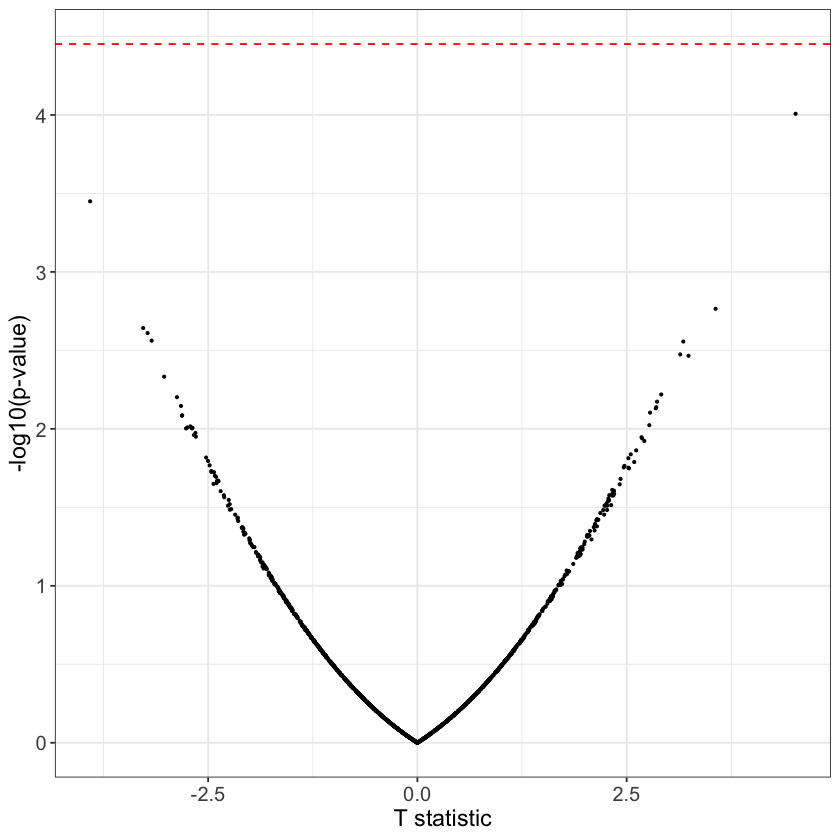

In [12]:
# Visualize results
bonferroni_adjusted_value <- 0.05 / dim(ttest_results_df)[1]

volcano_gg <- (
    ggplot(
        data = ttest_results_df,
        aes(x = test_statistic.t, y = -log10(p_value))
        )
    + geom_point(size = 0.5)
    + geom_hline(
        yintercept = -log10(bonferroni_adjusted_value),
        linetype = "dashed",
        color = "red"
        )
    + labs(x = "T statistic", y = "-log10(p-value)")
    + theme_bw()
    + theme(
        axis.title = element_text(size = 14),
        axis.text = element_text(size = 12)
        )
)

# Save plot
ggsave(volcano_plot_file, dpi = 400, width = 4, height = 4)

volcano_gg